shahin total profit 2.071940000000012
shahin Number of trades 5001
shahin max open positions 100.0
trend line 0 total profit 1.9133300000000588
trend line 0 Number of trades 5000
trend line 0 max open positions 100.0
10.726000652618994


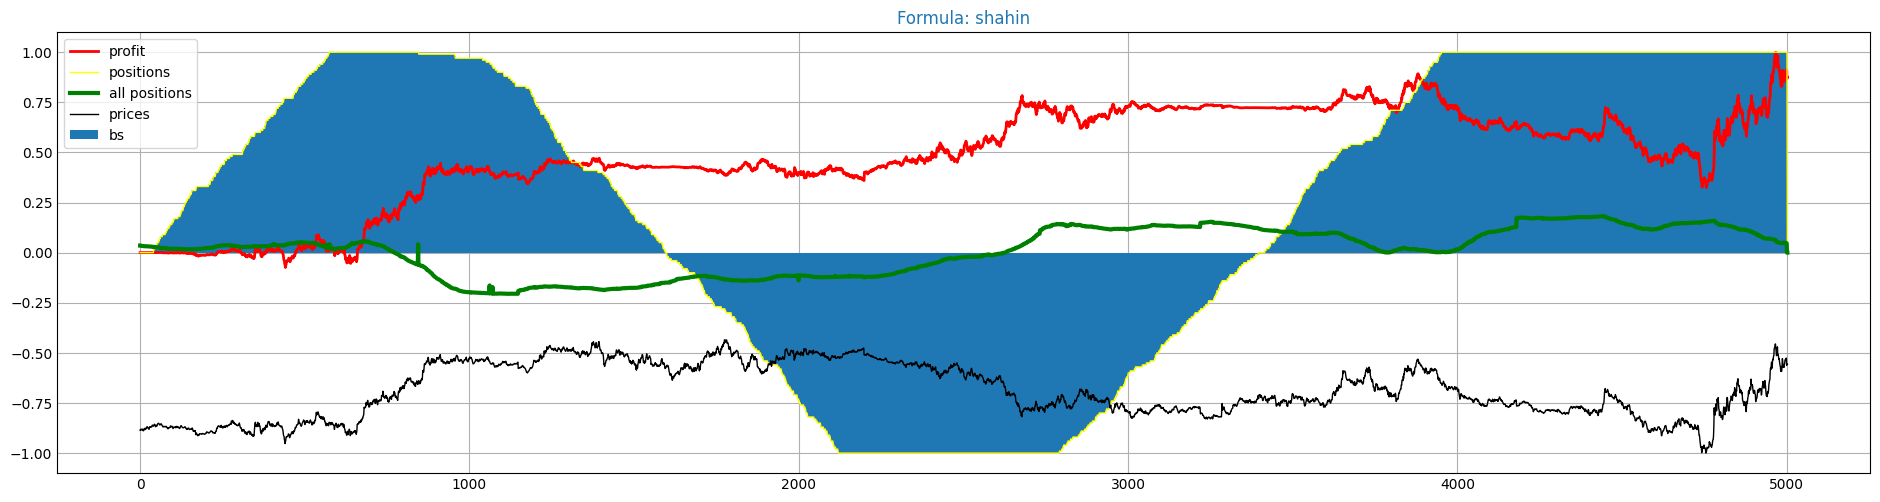

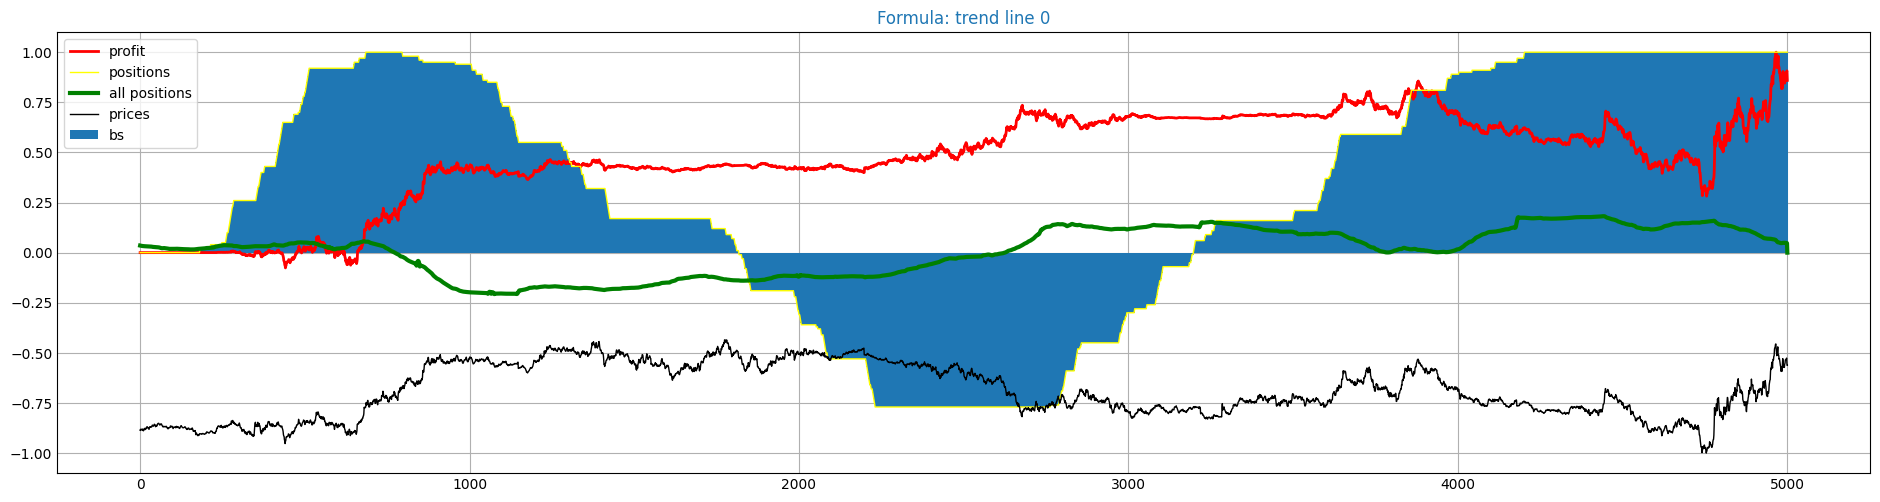

In [1]:
import math

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import account
import scipy.signal as sci

import data

ask_prices, bid_prices, longs, shorts = data.read("../input/sample/1_min_1_month.csv")
positions = [(i / (i + j)) if i + j != 0 else 0 for i, j in zip(longs, shorts)]
normalized_positions = positions


def shahin(prices, longs, shorts, step):
    if step < 40 :
        return 0
    long_percent = longs[step]/(longs[step] + shorts[step])

    if 0.5 < long_percent  and \
         longs[step-1]  < longs[step] and longs[step-1] < longs[step - 3 ]:
            return 1
    elif  long_percent < 0.5 and shorts[step-1] < shorts[step] and shorts[step-1] < \
            shorts[step -3] :
            return -1
    return 0

def shahin1(prices, longs, shorts, step):
    if step < 40 :
        return 0
    long_percent = longs[step]/(longs[step] + shorts[step])
    price_fit = np.polyfit(range(step - 30, step), [ (p - prices[step-30]) * 10000
                                                     for p in prices[step-30:step]],  1)
    if 0.5 < long_percent  and \
         longs[step-1]  < longs[step] and longs[step-1] < longs[step - 3 ]:
        if  price_fit[0] < -0.9:
            print(f"price fit ${price_fit[0]}")
            return -10
        return 1
    elif  long_percent < 0.5 and shorts[step-1] < shorts[step] and shorts[step-1] < \
            shorts[step -3] :
        return -1
    return 0
shorts_smooth = data.savitzky_golay(shorts, 11, 3)
longs_smooth = data.savitzky_golay(longs, 11, 3)

class TrendOnNormal:

    def __init__(self, degree):
        self.degree = degree
        self.max = 0
    def calc(self, prices, longs, shorts, step):
        if step < 40:
            return 0
        long = np.polyfit(range(0,40), [ (p1 - normalized_positions[step-40]) * 100
                                              for p1 in normalized_positions[step-40:step]],1)
        short = np.polyfit(range(0,4), [ (p1 - normalized_positions[step-4]) * 100
                                              for p1 in normalized_positions[step-4:step]],1)
        long_degree = math.atan(long[0])*180/math.pi
        if long_degree > self.max:
            self.max = long_degree
        short_degree = math.atan(short[0])*180/math.pi
        if normalized_positions[step] > 0.5 and long_degree > 0 and short_degree < 0 and \
 long_degree - short_degree > self.degree:
            return 1
        if normalized_positions[step] < 0.5 and long_degree < 0 and short_degree > 0 and \
 short_degree - long_degree > self.degree:
            return -1
        return 0

class Trendlines:

    def __init__(self, degree):
        self.degree = degree

    def calc(self, prices, longs, shorts, step):
        if step < 40:
            return 0
        long_percent = longs[step]/(longs[step] + shorts[step])
        long_long = np.polyfit(range(0,40), [ (p1 - longs[step-40]) * 1000
                                              for p1 in longs[step-40:step]],1)
        long_short = np.polyfit(range(0,4), [ (p1 - longs[step-4]) * 1000
                                              for p1 in longs[step-4:step]],1)
        long_long_degree = math.atan(long_long[0])
        long_short_degree = math.atan(long_short[0])

        short_long = np.polyfit(range(0,40), [ (p1 - shorts[step-40])
                                              for p1 in shorts[step-40:step]],1)
        short_short = np.polyfit(range(0,4), [ (p1 - shorts[step-4])
                                              for p1 in shorts[step-4:step]],1)
        short_long_degree = math.atan(short_long[0])*180/math.pi
        short_short_degree = math.atan(short_short[0])*180/math.pi

        if long_percent > 0.5 and long_long_degree > 0 and long_short_degree < 0 and \
 long_long_degree - long_short_degree > self.degree*180/math.pi:
            return 1
        if long_percent < 0.5 and short_long_degree < 0 and short_short_degree > 0 and \
180 + short_long_degree - short_short_degree >  self.degree*180/math.pi:
            return -1
        return 0


class Trader1:
    def __init__(self):
        self.last = 0
        self.std = []

    def only_50_avg(self, prices, longs, shorts, step):
        if step < 40:
            return 0
        long_percent = longs[step]/(longs[step] + shorts[step])
        long_forty_avg = np.average(longs[step-40:step])
        long_std = np.std(longs[step-40:step])
        short_std = np.std(shorts[step-40:step])
        shorts_forty_avg = np.average(shorts[step-40:step])

        price_fit = np.polyfit(range(step - 30, step), [ (p - prices[step-30]) * 10000
                                                         for p in prices[step-30:step]],  1)

        if long_percent > 0.5 and longs[step] < long_forty_avg - 2 * long_std:
            if  price_fit[0] < -0.7:
                return -10
            else:
                return 10
        if long_percent < 0.5 and shorts[step] > shorts_forty_avg + 2 * short_std:
            return -10
        else:
            return 0

t = Trader1()

def f( prices, longs, shorts, step):
    return t.only_50_avg( prices, longs, shorts, step)

# wallet1 = account.simulate(bid_prices, ask_prices, longs, shorts, [t.only_50_avg])
# wallet1.close(ask_prices[len(ask_prices) -1])
#
wallet2 = account.simulate(bid_prices, ask_prices, longs, shorts, [shahin])
wallet2.close(ask_prices[len(ask_prices) -1])
wallet2.draw("shahin")
#
# wallet3 = account.simulate(bid_prices, ask_prices, longs, shorts, [shahin1])
# wallet3.close(ask_prices[len(ask_prices) -1])

trend_line = TrendOnNormal(0)
wallet3 = account.simulate(bid_prices, ask_prices, longs_smooth, shorts_smooth, [trend_line.calc])

# trend_line = TrendOnNormal(0.05)
# wallet4 = account.simulate(bid_prices, ask_prices, longs_smooth, shorts_smooth, [trend_line.calc])
wallet3.draw("trend line 0")
print(trend_line.max)
# wallet4.print("trend line 20")
# wallet2.draw('shahin')
# wallet3.draw('shahin1')

ask price size 500
smooth size 500


<BarContainer object of 10 artists>

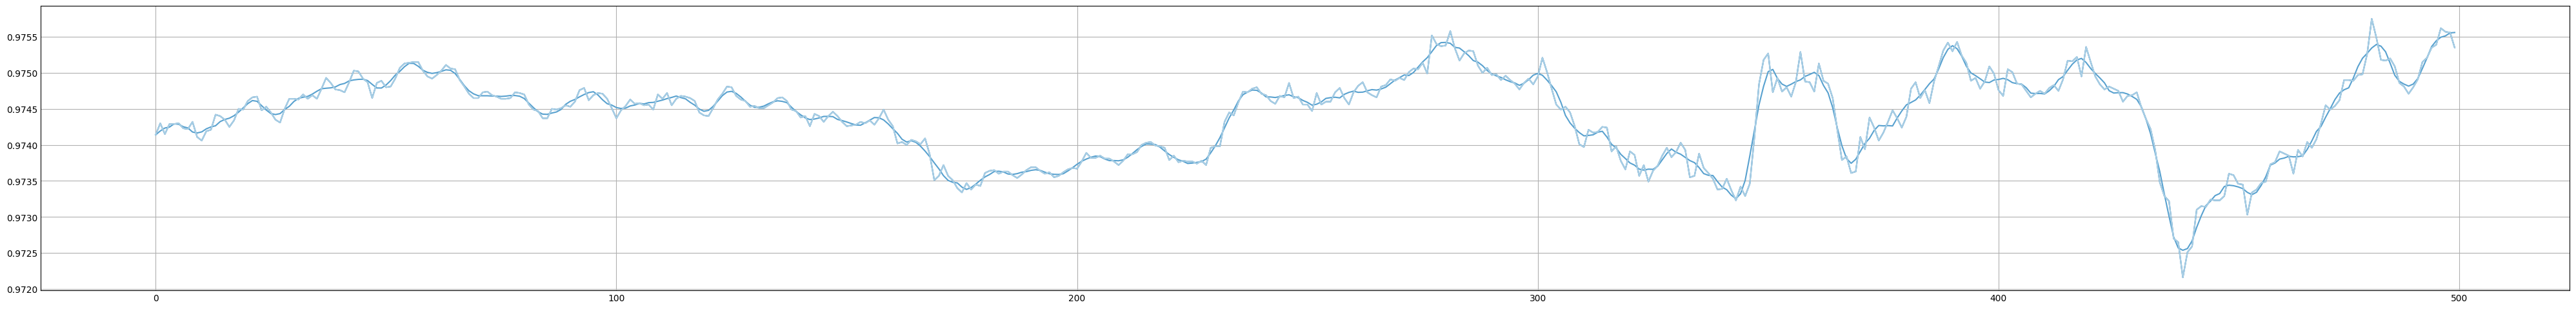

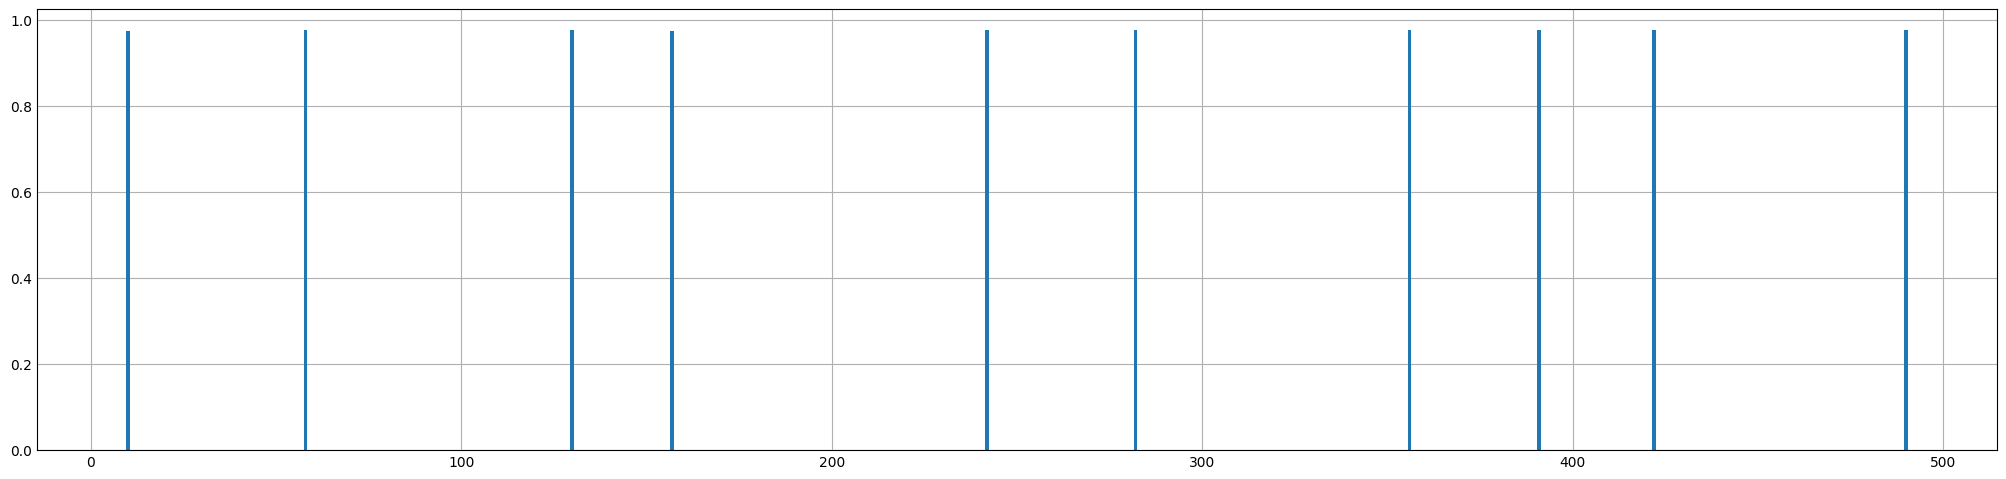

In [3]:
import data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import account
import scipy.signal as sci

ask_prices, bid_prices, longs, shorts = data.read("../input/sample/1_min_1_month.csv", 500)
x = np.linspace(0, len(ask_prices), len(ask_prices))

fig, ax = plt.subplots()
fig.set_size_inches(40, 4.5)
ax.plot( ask_prices)
peaks = sci.find_peaks_cwt(ask_prices, 10)
smooth1 = data.savitzky_golay(ask_prices, 11, 3)
print(f"ask price size {len(ask_prices)}")
print(f"smooth size {len(smooth1)}")
peaks = sci.find_peaks_cwt(smooth1, 10)
ax.plot( smooth1)

ax.plot(ask_prices)
m = []
for p in peaks:
    m.append(smooth1[p])

fig1, ax1 = plt.subplots()
fig1.set_size_inches(20, 4.5)
ax1.bar(peaks, m, width=1)
# plt.ylim(0.6, 1.2)